<a href="https://colab.research.google.com/github/003084-K/cardsort/blob/Architecture/WCST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

%matplotlib inline 

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

## Data Pre-Processing

Convention for mock data:

Row 1 = shape  
Row 2 = number  
Row 3 = color

In [0]:
# Make 1-hot encoded numpy array for each card
card_list = np.zeros((64,3,4))

In [4]:
card_list.shape

(64, 3, 4)

In [0]:
for i, (shape, number, color) in enumerate(itertools.product(range(0,4), range(0,4), range(0,4))):
    card_list[i][0][shape] = 1
    card_list[i][1][number] = 1
    card_list[i][2][color] = 1

In [0]:
card_list

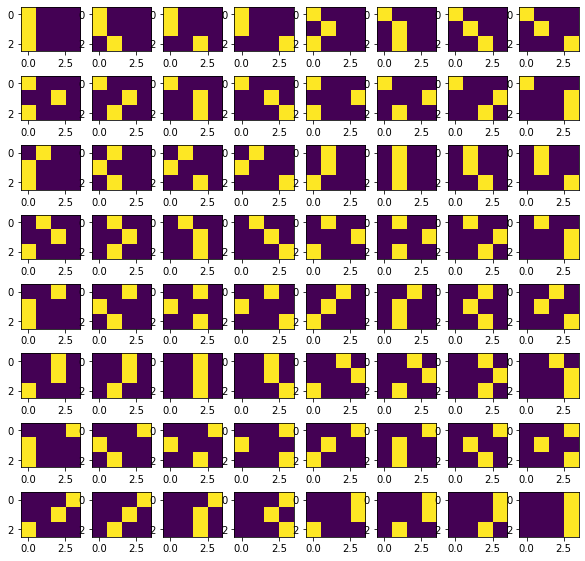

In [6]:
f, ax = plt.subplots(nrows=8, ncols=8, figsize=[10,10])
for i in range(0, card_list.shape[0]):
    ax.flatten()[i].imshow(card_list[i])
# plt.tight_layout()
plt.show() 

In [0]:
# goal: be able to randomly sample from all possible sets of cards as quickly as possible
# solution: pre-determine all possible combinations of cards given each test card and store for future stochastic sampling
# we can randomly shuffle the order of cards in a given set when generating batches

In [0]:
sets = []

# for each probe card, determine all possible sets
for p_card in card_list:
  # first determine all cards matching in shape (but not other features)
  for s_card in card_list:
    if (np.sum((s_card==p_card),axis=1)==(4,2,2)).all():
      # for each card that matches in number (but not other features) that doesn't share features with shapecard
      for n_card in card_list:
        if (np.sum((n_card==p_card),axis=1)==(2,4,2)).all() and (np.sum((n_card==s_card),axis=1)==(2,2,2)).all():
          # for each card that matches in color (but not other features) that doesn't share features with shapecard or numcard
          for c_card in card_list:
            if (np.sum((c_card==p_card),axis=1)==(2,2,4)).all() and (np.sum((c_card==s_card),axis=1)==(2,2,2)).all() and (np.sum((c_card==n_card),axis=1)==(2,2,2)).all():
            # for each card that matches in no features that doesn't share features with shapecard or numcard or colorcard
              for no_card in card_list:
                if (np.sum((no_card==p_card),axis=1)==(2,2,2)).all() and (np.sum((no_card==s_card),axis=1)==(2,2,2)).all() and (np.sum((no_card==n_card),axis=1)==(2,2,2)).all() and (np.sum((no_card==c_card),axis=1)==(2,2,2)).all():
                # save whole set
                  sets.append((s_card,n_card,c_card,no_card,p_card))

sets = np.array(sets)

In [8]:
sets.shape

(13824, 5, 3, 4)

# Architecture

In [0]:
class MultiNet(nn.Module):
    def __init__(self):
        super(MultiNet, self).__init__()

        # determine encoding for a card
        self.encoding = nn.Sequential(nn.Linear(12, 6), # single card has 12 features
                                nn.ReLU(),  # Do we need this nonlinearity? can't this network be a single layer from 12 to 2?
                                nn.Linear(6, 2))


    def forward(self, x):
        c1_fs = self.encoding(x[0])
        c2_fs = self.encoding(x[1])
        c3_fs = self.encoding(x[2])
        c4_fs = self.encoding(x[3])
        p_fs = self.encoding(x[4])

        dists = (torch.dist(p_fs, c1_fs), torch.dist(p_fs, c2_fs), torch.dist(p_fs, c3_fs), torch.dist(p_fs, c4_fs)) # compare each feature representation to that of probe card

        return F.log_softmax(-dists)    # softmax of negative distance means things closer have larger confidence
        # network should learn to ignore all features except match feature in generating feature representations

# Training, Optimizer, Loss